In [1]:
# Libraries

import geemap, ee
import matplotlib.pyplot as plt

print("Libraries imported")

# Authenticate Google Earth Engine and initialize project

ee.Authenticate()
ee.Initialize(project="geog-581-483717")

print("Authenticated and initialized")

/Users/marcel/Desktop/geog581-gee-notebook/venv/lib/python3.10/site-packages/google/api_core/_python_version_support.py:275: FutureWarning: You are using a Python version (3.10.4) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)


Libraries imported
Authenticated and initialized


In [2]:
# Load Sentinel-2 image collection

sentinel_2 = "COPERNICUS/S2_HARMONIZED"

try:
    S2 = ee.ImageCollection("COPERNICUS/S2_HARMONIZED")
except:
    print(f"Failed to load dataset {sentinel_2}")
else:
    print(f"Successfully loaded {sentinel_2}")


Successfully loaded COPERNICUS/S2_HARMONIZED


In [3]:
# Create point geometries for sites of interest

# 1. Water/coast boundary at -124.14447784423828, 43.95303488136496
water = ee.Geometry.Point([-124.14447784423828, 43.95303488136496])

# 2. Forest/agriculture mosaic at -123.36410522460938, 44.22847252552762
forest = ee.Geometry.Point([-123.36410522460938, 44.22847252552762])

# 3. Urban mosaic at -123.1344223022461, 44.050089820756796
urban = ee.Geometry.Point([-123.1344223022461, 44.050089820756796])

In [4]:
# Create an area of interest polygon by creating a buffer around each point 
water_buffer = water.buffer(200)
forest_buffer = forest.buffer(200)
urban_buffer = urban.buffer(200)

# Look at the type after buffer function has been applied
print("Python Type:", type(water_buffer))
water_info = water_buffer.getInfo()
print("Google Earth Engine Type:", water_info["type"])


Python Type: <class 'ee.geometry.Geometry'>
Google Earth Engine Type: Polygon


In [5]:
# Filter Sentinel-2 collection spatially and temporally

# July 15, 2017 through July 31, 2017, and includes all of our areas of interest
S2_filtered = S2.filterDate('2017-07-15', '2017-07-31').filterBounds(water_buffer).filterBounds(forest_buffer).filterBounds(urban_buffer)

# Find number of images in filtered collection
n_images = S2_filtered.size().getInfo()
print("Number of images in S2_filtered collection:", n_images)


Number of images in S2_filtered collection: 4


In [6]:
# Get first image from collection
S2_first = S2_filtered.first()
first_date = ee.Date(S2_first.get("system:time_start")).format("YYYY-MM-dd HH:mm:ss").getInfo()
print("Date of the selected image (first in S2_filtered):", first_date)


Date of the selected image (first in S2_filtered): 2017-07-15 19:22:24


In [7]:
# Select Band 8 (Near Infrared)
S2_NIR = S2_first.select(8)


In [8]:
# Create histograms for each area of interest

water_hist = S2_NIR.reduceRegion(
    reducer=ee.Reducer.histogram(maxBuckets=256),
    geometry=water_buffer,
    scale=10,
    bestEffort=True,
    maxPixels=1e9,
)

forest_hist = S2_NIR.reduceRegion(
    reducer=ee.Reducer.histogram(maxBuckets=256),
    geometry=forest_buffer,
    scale=10,
    bestEffort=True,
    maxPixels=1e9,
)

urban_hist = S2_NIR.reduceRegion(
    reducer=ee.Reducer.histogram(maxBuckets=256),
    geometry=urban_buffer,
    scale=10,
    bestEffort=True,
    maxPixels=1e9,
)

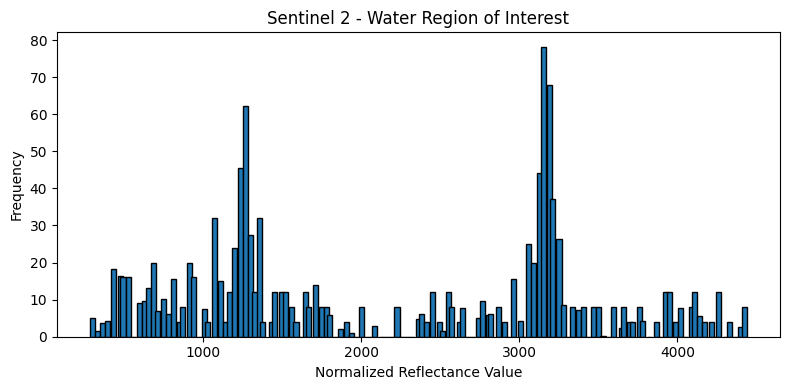

In [9]:
# Water R.O.I. histogram

water_hist_info = water_hist.getInfo()
water_hist_b8a = water_hist_info["B8A"]

x = water_hist_b8a["bucketMeans"] 
y = water_hist_b8a["histogram"]  
w = water_hist_b8a.get("bucketWidth", None)
if w is None and len(x) > 1:
    w = x[1] - x[0]
elif w is None:
    w = 1

plt.figure(figsize=(8, 4))
plt.bar(x, y, width=w, align="center", edgecolor="black")
plt.title("Sentinel 2 - Water Region of Interest")
plt.xlabel("Normalized Reflectance Value")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

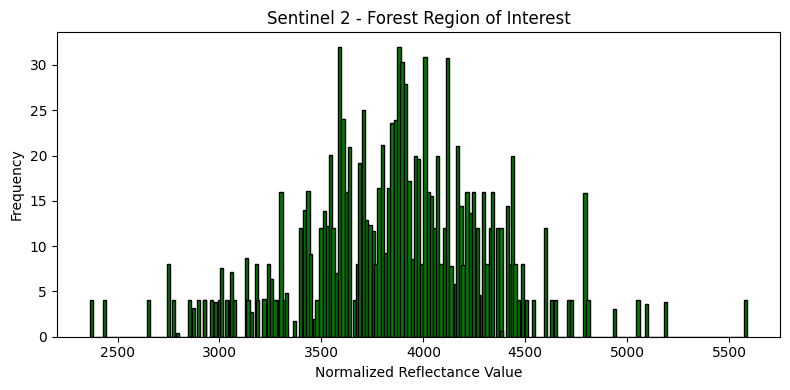

In [10]:
# Forest R.O.I. histogram

forest_hist_info = forest_hist.getInfo()
forest_hist_b8a = forest_hist_info["B8A"]

x = forest_hist_b8a["bucketMeans"] 
y = forest_hist_b8a["histogram"]  
w = forest_hist_b8a.get("bucketWidth", None)
if w is None and len(x) > 1:
    w = x[1] - x[0]
elif w is None:
    w = 1

plt.figure(figsize=(8, 4))
plt.bar(x, y, width=w, align="center", edgecolor="black", color="green")
plt.title("Sentinel 2 - Forest Region of Interest")
plt.xlabel("Normalized Reflectance Value")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

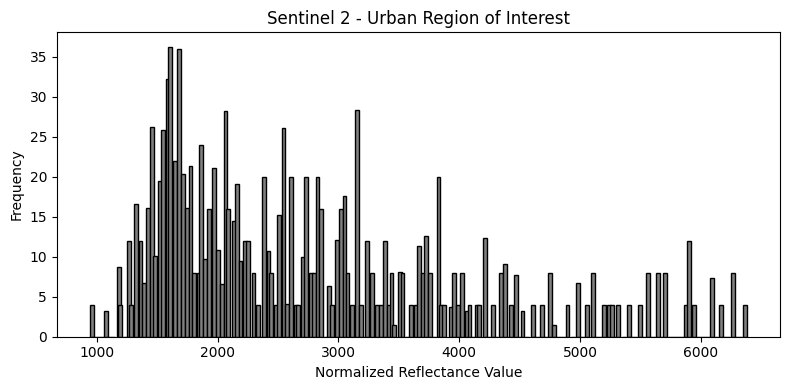

In [11]:
# Urban R.O.I. histogram

urban_hist_info = urban_hist.getInfo()
urban_hist_b8a = urban_hist_info["B8A"]

x = urban_hist_b8a["bucketMeans"] 
y = urban_hist_b8a["histogram"]  
w = urban_hist_b8a.get("bucketWidth", None)
if w is None and len(x) > 1:
    w = x[1] - x[0]
elif w is None:
    w = 1

plt.figure(figsize=(8, 4))
plt.bar(x, y, width=w, align="center", edgecolor="black", color="gray")
plt.title("Sentinel 2 - Urban Region of Interest")
plt.xlabel("Normalized Reflectance Value")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [12]:
# Get range of potential values for Band 8 (NIR) from metadata

s2_nir_info = S2_NIR.getInfo()

dt = s2_nir_info["bands"][0]["data_type"]
nir_min = dt["min"]
nir_max = dt["max"]

print(f"Band 8 Range - Minimum: {nir_min}, Maximum: {nir_max}")

Band 8 Range - Minimum: 0, Maximum: 65535


In [13]:
# Visualize NIR Band

Map = geemap.Map(ee_initialize=False)

gray_vis = {
    "min": nir_min,
    "max": nir_max,
    "palette": ["000000", "FFFFFF"],
}

Map.addLayer(S2_NIR, gray_vis, name="S2 Band 8 (NIR) - Original")

water_roi = ee.FeatureCollection([ee.Feature(water_buffer, {"name": "Water ROI"})])
forest_roi = ee.FeatureCollection([ee.Feature(forest_buffer, {"name": "Forest ROI"})])
urban_roi = ee.FeatureCollection([ee.Feature(urban_buffer, {"name": "Urban ROI"})])

Map.addLayer(water_roi.style(color="0000FF", width=2, fillColor="0000FF33"),{},"Water buffer (ROI)",)
Map.addLayer(forest_roi.style(color="00FF00", width=2, fillColor="00FF0033"),{},"Forest buffer (ROI)",)
Map.addLayer(urban_roi.style(color="FF0000", width=2, fillColor="FF000033"),{},"Urban buffer (ROI)",)

center  = ee.Geometry.Point([-123.6676, 44.0679])
Map.centerObject(center, 9)
Map

Map(center=[44.0679, -123.6676], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(c…

In [14]:
# Apply a percent-stretch to the data
# stretched_value = ((input_value - minimum_value) / (maximum_value - minimum_value)) * range

nir_minmax = S2_NIR.reduceRegion(
    reducer=ee.Reducer.minMax(),
    geometry=S2_NIR.geometry(),
    scale=10,
    bestEffort=True,
    maxPixels=1e9,
    tileScale=4,
)

minmax_info = nir_minmax.getInfo()

nir_min_actual = ee.Number(nir_minmax.get("B8A_min"))
nir_max_actual = ee.Number(nir_minmax.get("B8A_max"))
nir_range = nir_max - nir_min
denom = (nir_max_actual.subtract(nir_min_actual))
nir_stretched = (S2_NIR.subtract(nir_min_actual).divide(denom).multiply(nir_range))

water_pt = ee.FeatureCollection([ee.Feature(water, {"name": "Water ROI"})])
forest_pt = ee.FeatureCollection([ee.Feature(forest, {"name": "Forest ROI"})])
urban_pt = ee.FeatureCollection([ee.Feature(urban, {"name": "Urban ROI"})])

Map2 = geemap.Map(ee_initialize=False)
Map2.addLayer(S2_NIR, gray_vis, name="S2 Band 8 (NIR) - Original")
Map2.addLayer(nir_stretched, gray_vis, name="S2 Band 8 (NIR) - Stretched")
Map2.addLayer(water_pt.style(color="0000FF", pointSize=1), {}, "Water point")
Map2.addLayer(forest_pt.style(color="00FF00", pointSize=1), {}, "Forest point")
Map2.addLayer(urban_pt.style(color="FF0000", pointSize=1), {}, "Urban point")
Map2.centerObject(center, 9)
Map2


Map(center=[44.0679, -123.6676], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(c…

In [15]:
# Compile a kernel and convolve over the original image

one_d_list = [1, 1, 1]
center_list = [1, 0, 1]
two_d_list = [one_d_list, center_list, one_d_list]
kernel = ee.Kernel.fixed(3, 3, two_d_list, -1, -1, normalize=True)

nir_smoothed = nir_stretched.convolve(kernel)

Map3 = geemap.Map(ee_initialize=False)
Map3.addLayer(nir_stretched, gray_vis, name="S2 Band 8 (NIR) - Stretched")
Map3.addLayer(nir_smoothed, gray_vis, name="S2 Band 8 (NIR) - Smoothed")
Map3.addLayer(water_pt.style(color="0000FF", pointSize=1), {}, "Water point")
Map3.addLayer(forest_pt.style(color="00FF00", pointSize=1), {}, "Forest point")
Map3.addLayer(urban_pt.style(color="FF0000", pointSize=1), {}, "Urban point")
Map3.centerObject(center, 9)
Map3

Map(center=[44.0679, -123.6676], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(c…

In [16]:
# Apply maximum stretch filter with different iteration arguments to compare

kernel_size = 3
kernel_shape = 'square'
output_max_1 = nir_stretched.focal_max(kernel_size, kernel_shape, 'pixels', 1)
output_max_3 = nir_stretched.focal_max(kernel_size, kernel_shape, 'pixels', 3)

Map4 = geemap.Map(ee_initialize=False)
Map4.addLayer(S2_NIR, gray_vis, name="S2 Band 8 (NIR) - Original")
Map4.addLayer(output_max_1, gray_vis, name="S2 Band 8 (NIR) - Focal Max 1")
Map4.addLayer(output_max_3, gray_vis, name="S2 Band 8 (NIR) - Focal Max 3")
Map4.addLayer(water_pt.style(color="0000FF", pointSize=1), {}, "Water point")
Map4.addLayer(forest_pt.style(color="00FF00", pointSize=1), {}, "Forest point")
Map4.addLayer(urban_pt.style(color="FF0000", pointSize=1), {}, "Urban point")
Map4.centerObject(center, 9)
Map4


Map(center=[44.0679, -123.6676], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(c…

In [17]:
# Apply a laplacian kernel
laplacian_kernel = ee.Kernel.laplacian8()
nir_sharpened = nir_stretched.convolve(laplacian_kernel)
print(laplacian_kernel.getInfo())

Map5 = geemap.Map(ee_initialize=False)
Map5.addLayer(nir_stretched, gray_vis, name="S2 Band 8 (NIR) - Original")
Map5.addLayer(nir_sharpened, gray_vis, name="S2 Band 8 (NIR) - Focal Max 1")
Map5.addLayer(water_pt.style(color="0000FF", pointSize=1), {}, "Water point")
Map5.addLayer(forest_pt.style(color="00FF00", pointSize=1), {}, "Forest point")
Map5.addLayer(urban_pt.style(color="FF0000", pointSize=1), {}, "Urban point")
Map5.centerObject(center, 9)
Map5

{'type': 'Kernel.laplacian8', 'center': [1, 1], 'weights': '\n  [1.0, 1.0, 1.0]\n  [1.0, -8.0, 1.0]\n  [1.0, 1.0, 1.0]'}


Map(center=[44.0679, -123.6676], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(c…

In [18]:

# Calculate NDVI & EVI for a Landsat 8 image
from ipyleaflet import SplitMapControl

sodak_L8 = ee.Image('LANDSAT/LC08/C02/T1_TOA/LC08_030029_20170714')

ndvi = sodak_L8.normalizedDifference(['B5', 'B4'])

evi = sodak_L8.expression('(NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1)', {'NIR': sodak_L8.select('B5'), 'RED': sodak_L8.select('B4'), 'BLUE': sodak_L8.select('B2')})

vegVisParams = {min: 0, max: 1, "palette": ['FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718', '74A901', '66A000', '529400', '3E8601', '207401', '056201', '004C00', '023B01', '012E01', '011D01', '011301']}

left_layer  = geemap.ee_tile_layer(ndvi, vegVisParams, "NDVI")
right_layer = geemap.ee_tile_layer(evi,  vegVisParams, "EVI")

center  = ee.Geometry.Point([-98.2233, 44.7818])

legend_dict = {
    "Low": "#FFFFFF",
    "Moderately Low": "#DF923D",
    "Moderately High": "#74A901",
    "High": "#012E01",
}

Map6 = geemap.Map(ee_initialize=False)
Map6.add_control(SplitMapControl(left_layer=left_layer, right_layer=right_layer))
Map6.centerObject(center, 10)
Map6.add_legend(title="Vegetation Index", legend_dict=legend_dict, position="bottomright",)
Map6

Map(center=[44.7818, -98.22330000000001], controls=(WidgetControl(options=['position', 'transparent_bg'], widg…

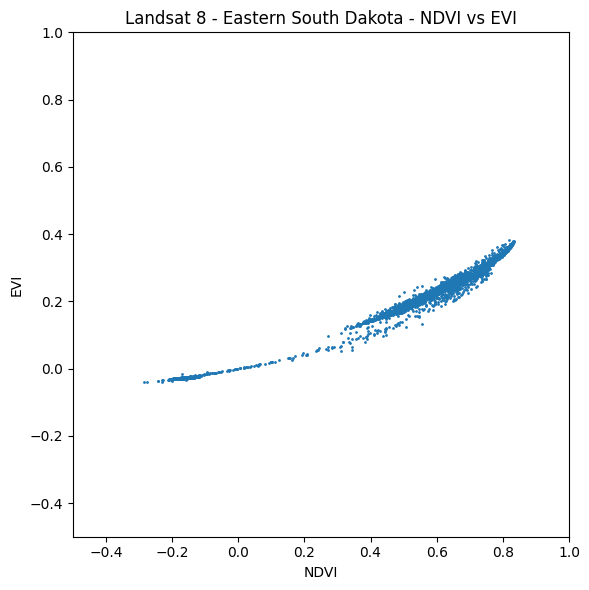

In [19]:
# Construct scatter plots for region

region = ee.Geometry.Polygon(
        [[[-97.66193389892578, 44.644475425739515],
          [-97.6358413696289, 44.64398688859383],
          [-97.6358413696289, 44.66010644213108],
          [-97.66124725341797, 44.66010644213108]]])

scale = 30

values_NDVI = ndvi.reduceRegion(ee.Reducer.toList(), region, scale).values().get(0).getInfo()
values_EVI = evi.reduceRegion(ee.Reducer.toList(), region, scale).values().get(0).getInfo()

# Generate scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(values_NDVI, values_EVI, s=1)
plt.xlabel("NDVI")
plt.ylabel("EVI")
plt.xlim(-0.5, 1.0)
plt.ylim(-0.5, 1.0)
plt.title("Landsat 8 - Eastern South Dakota - NDVI vs EVI")
plt.tight_layout()
plt.show()



In [20]:
# Generate NDVI and EVI difference map

evi_minus_ndvi = evi.subtract(ndvi).rename("EVI_minus_NDVI")
diff_vis = {"min": -0.5, "max": 0.5, "palette": ["0000FF", "FFFFFF", "FF0000"]}
Map7 = geemap.Map(ee_initialize=False)
Map7.addLayer(evi_minus_ndvi, diff_vis, "EVI - NDVI")
Map7.centerObject(center, 10)
Map7


Map(center=[44.7818, -98.22330000000001], controls=(WidgetControl(options=['position', 'transparent_bg'], widg…